# Imports and Data

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import phonecalls as pc
import scipy.stats as stats
import time
import copy
import os


plt.rcParams['figure.figsize'] = (20, 10)
markers = ['o', 'v', 's', 'P', '*', 'X', 'd', 'x', 'D', '2', '+']

calls = {}
pairs = {}
lives = {}

## MIT

A different approach. I will create a dictionary with the calls data fro all three cohorts. This time, I will keep all egos, because I will make some constraints to the data in order to make pairs of ego-alter comparable, even if they appeared at different points in time. 

In [2]:
%time calls['mit'] = pc.allcalls('CallLog.csv', (), 'participantID.A', 'number.hash', ['local_time'], "%Y-%m-%d %H:%M:%S", header=True, min_activity=1)
calls['mit'].head()

CPU times: user 406 ms, sys: 44.8 ms, total: 451 ms
Wall time: 483 ms


,ego,alter,time,uclock,aclock
0,fa10-01-19,10153fa58c24d1a2eb54b3c6ac39482acb61131c,2010-12-31 16:44:24,307,0
1,fa10-01-22,101b96d65031e2792acd950125d90cf9ff30b5ac,2011-05-23 20:59:05,450,0
2,fa10-01-12,1023b616632f3ba048b2f1d1374788bfa0444a8d,2011-01-22 14:01:07,328,0
3,fa10-01-01,102c517fc9ecf84975448470893c3799f5588c8a,2011-05-27 17:52:56,454,0
4,fa10-01-07,102cd812edb5689302bcc57df8330cff44727bd1,2011-04-04 10:02:50,400,0


In [3]:
%time pairs['mit'] = pc.pairs(calls['mit'])
%time lives['mit'] = pc.lives_dictionary(calls['mit'])

CPU times: user 40.1 ms, sys: 1.2 ms, total: 41.3 ms
Wall time: 40.9 ms
CPU times: user 157 ms, sys: 3.71 ms, total: 161 ms
Wall time: 161 ms


## UK

I need to divide the UK dataset in two cohorts: `uk1` contains all alters appeared in the first six months of data; and `uk2` all alters appearing after six months

In [4]:
tmp1 = pc.allcalls("../ukdata/collected_dunbar_calls_v3_e26OK_sorted.csv", (3, 'call'), 1, 2, [6,7], '%d/%m/%y %H:%M', header=False, min_activity=1)
tmp1.head()

,ego,alter,time,uclock,aclock
0,C07814508939,C0020165636994,2008-02-07 16:18:00,339,0
1,C07814508939,C0020165636994,2008-02-07 17:11:00,339,0
2,C07814508939,C0020165636994,2008-02-20 15:39:00,352,13
3,C07792658311,C0021213487966,2008-02-27 17:01:00,359,0
4,C07792658311,C0021213487966,2008-02-27 17:55:00,359,0


In [5]:
# Temporary data, since I will create two cohorts out of these
tmp2 = pc.pairs(tmp1)
tmp3 = pc.lives_dictionary(tmp1)

In [6]:
rmalter = {}
for ego in tmp3.keys():
    rmalter[ego] = []
    for alter in tmp3[ego].keys():
        if tmp3[ego][alter]['t0'] < 180:
            rmalter[ego].append(alter)
            
for i in tmp1.index:
    ego = tmp1.at[i, 'ego']
    alter = tmp1.at[i, 'alter']
    if alter in rmalter[ego]:
        tmp1.at[i, 'rm'] = 1
    else:
        tmp1.at[i, 'rm'] = 0

calls['uk1'] = tmp1.loc[tmp1['rm'] == 1]
calls['uk1'].drop(columns=['rm'], inplace=True)
calls['uk1'].reset_index(drop=True, inplace=True)

new = tmp1.loc[tmp1['rm'] == 0]
new = new.loc[new['uclock'] >= 180]
new['uclock'] -= 180
new.to_csv("tmp2.csv")
calls['uk2'] = pc.allcalls("tmp2.csv", (), 'ego', 'alter', ['time'], '%Y-%m-%d %H:%M:%S')
calls['uk2'].reset_index(drop=True, inplace=True)
os.system("rm tmp2.csv")

/home/vsvh/.local/lib/python3.9/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


0

In [7]:
len(calls['uk1']) + len(calls['uk2']) == len(tmp1)

True

In [8]:
for c in ['uk1', 'uk2']:
    pairs[c] = pc.pairs(calls[c])
    lives[c] = pc.lives_dictionary(calls[c])

# Limit data

In order to make all pairs of ego-alters (in all three cohorts comparable, I will limit the amount of phone calls to be analized, using the following criteria:

1. Only consider phone calls made by egos 30 days or later than their first appeareance.
2. For each alter, its maximum value of $a$ will be 200 days. This makes $\max_{\ell} = 200$.
3. Remove all alters whose first appeareance was **after** $T - \max{a}$. This is to guarantee that every alter could potentially reach $\max{a}$.

## Remove first 30 days of activity for each ego

In [9]:
calls.keys()

dict_keys(['mit', 'uk1', 'uk2'])

In [10]:
for c in calls.keys():
    uno = calls[c].groupby('ego')[['uclock']].min()
    dos = pd.DataFrame()
    for ego in calls[c]['ego'].unique():
        df = calls[c].loc[calls[c]['ego'] == ego]
        minday = uno.loc[ego]['uclock'] + 30
        df1 = df.loc[df['uclock'] >= minday]
        dos = dos.append(df1).reset_index(drop=True)
    old = len(calls[c])
    calls[c] = dos
    print(f'{c} lost {old - len(calls[c])} calls')

mit lost 19098 calls
uk1 lost 5733 calls
uk2 lost 1684 calls


## Limit $\max{a}$ to 200

In [11]:
for c in calls.keys():
    old = len(calls[c])
    calls[c] = calls[c].loc[calls[c]['aclock'] <= 200]
    print(f'{c} lost {old - len(calls[c])} calls')

mit lost 24426 calls
uk1 lost 37748 calls
uk2 lost 3229 calls


## Remove all alters with $t(0) > T - \max{a}$

In [12]:
for c in calls.keys():
    uno = pd.DataFrame()
    T = max(calls[c]['uclock'])
    for ego in calls[c]['ego'].unique():
        df = calls[c].loc[calls[c]['ego'] == ego]
        for alter in df['alter'].unique():
            df2 = df.loc[df['alter'] == alter]
            if min(df2['uclock']) < (T - 200):
                uno = uno.append(df2).reset_index(drop=True)
    old = len(calls[c].groupby(['ego', 'alter'])[['aclock']].count())
    calls[c] = uno
    new = len(calls[c].groupby(['ego', 'alter'])[['aclock']].count())
    print(f'{c} lost {old - new} pairs of ego-alter')

mit lost 7649 pairs of ego-alter
uk1 lost 38 pairs of ego-alter
uk2 lost 1905 pairs of ego-alter


In [13]:
maxell = 0
for c in lives.keys():
    for ego in lives[c].keys():
        for alter in lives[c][ego].keys():
            ell = lives[c][ego][alter]['ell']
            if ell > maxell:
                maxell = ell
    print(f'{c} has max ell {maxell}')

mit has max ell 458
uk1 has max ell 534
uk2 has max ell 534


In [14]:
for c in calls.keys():
    pairs[c] = pc.pairs(calls[c])
    lives[c] = pc.lives_dictionary(calls[c])

In [15]:
maxell = 0
for c in lives.keys():
    for ego in lives[c].keys():
        for alter in lives[c][ego].keys():
            ell = lives[c][ego][alter]['ell']
            if ell > maxell:
                maxell = ell
    print(f'{c} has max ell {maxell}')

mit has max ell 200
uk1 has max ell 200
uk2 has max ell 200


# Histogram of $\ell$

Even considering that the lifetime of every alter is limited to $0 \leq \ell \leq 200$; to deal with the heterogeneous values I could find, I will use bins of 10 days to create $0 \leq \lambda \leq 20$

In [16]:
timer0 = time.time()
Hlamb = {}
for c in lives.keys():
    Hlamb[c] = {}
    for ego in lives[c].keys():
        for alter in lives[c][ego].keys():
            lamb = lives[c][ego][alter]['ell'] // 10
            Hlamb[c][lamb] = Hlamb[c].get(lamb, 0) + 1
    Hlamb[c] = pd.DataFrame.from_dict(Hlamb[c], orient='index')
    Hlamb[c].sort_index(inplace=True)
print(f'This block took {time.time() - timer0}')

This block took 0.005376577377319336


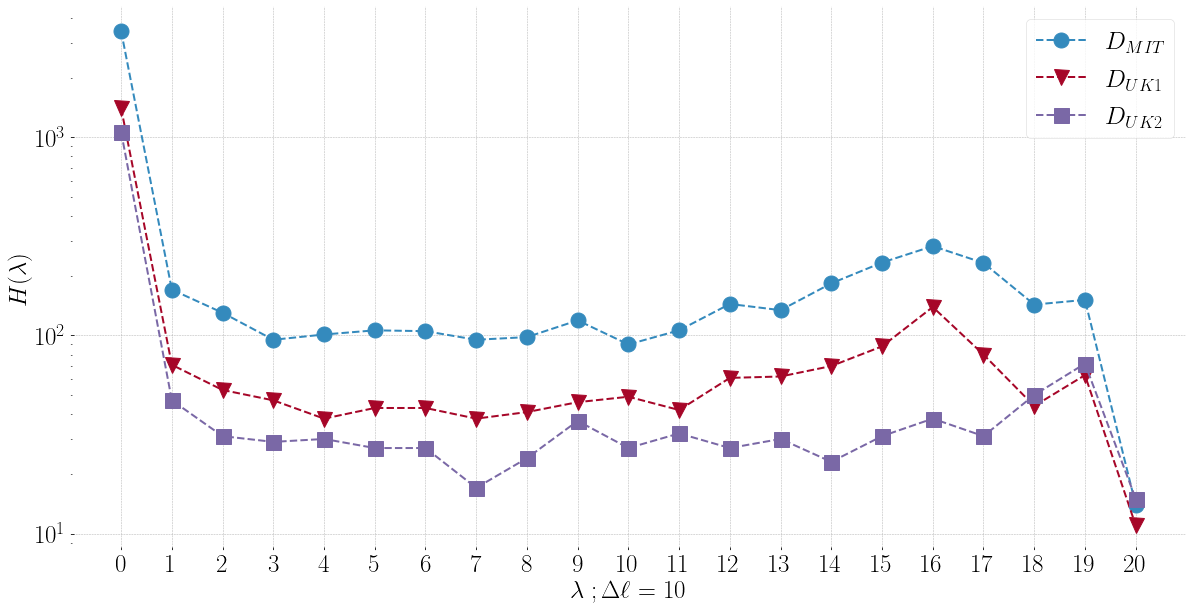

In [17]:
plt.xlabel(r'$\lambda \; ; \Delta \ell = 10$')
plt.ylabel(r'$H(\lambda)$')
plt.yscale("log")
plt.xticks(range(21))
m = 0
for c in Hlamb.keys():
    plt.plot(Hlamb[c].index, Hlamb[c][0], marker=markers[m], linestyle="--", markersize=15, label=fr"${['D_{MIT}', 'D_{UK1}', 'D_{UK2}'][m]}$")
    m += 1
plt.legend()

# Histogram of $a$

Similar to $\ell$, I will calculate the histogram of $a$ by taking bins of size 10. Thus, $0 \leq \alpha \leq 20$

In [18]:
timer0 = time.time()
Fa = {}
for c in calls.keys():
    Fa[c] = {}
    df = calls[c]
    df['alpha'] = df['aclock'] // 10
    df2 = df.groupby(['alpha'])[['aclock']].count()
    for i in df2.index:
        Fa[c][i] = df2.at[i, 'aclock']
    Fa[c] = pd.DataFrame.from_dict(Fa[c], orient='index')
    Fa[c].sort_index(inplace=True)
print(f'This block took {time.time() - timer0}')

This block took 0.00984954833984375


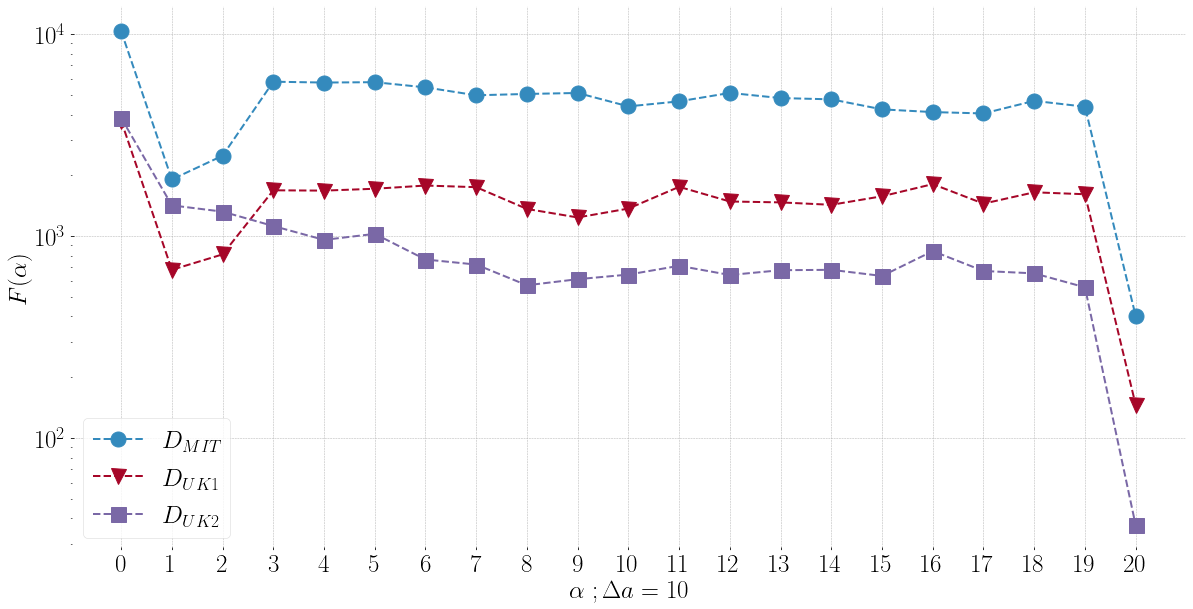

In [19]:
plt.xlabel(r'$\alpha \; ; \Delta a = 10$')
plt.ylabel(r'$F(\alpha)$')
plt.yscale("log")
plt.xticks(range(21))
m = 0
for c in Fa.keys():
    plt.plot(Fa[c].index, Fa[c][0], marker=markers[m], linestyle="--", markersize=15, label=fr"${['D_{MIT}', 'D_{UK1}', 'D_{UK2}'][m]}$")
    m += 1
plt.legend()

# $\langle b \rangle$ as a function of $\lambda$

In [20]:
dff = {}
for c in calls.keys():
    %time dff[c] = pc.get_f(calls[c], 'all', 70, 10)

/home/vsvh/docs/GMU/research/comm_patterns_git/phonecalls.py:204: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.sort_values(by='time', inplace=True)
/home/vsvh/docs/GMU/research/comm_patterns_git/phonecalls.py:209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['alpha'] = df3['aclock'] // bina


CPU times: user 9.08 s, sys: 4.63 ms, total: 9.09 s
Wall time: 9.09 s
CPU times: user 3.62 s, sys: 6.71 ms, total: 3.63 s
Wall time: 3.63 s
CPU times: user 2.38 s, sys: 3.57 ms, total: 2.39 s
Wall time: 2.39 s


In [21]:
bplot = {}
for c in dff.keys():
    %time b = pc.get_b(dff[c], 'lambda')
    %time bplot[c] = pc.plot_g(b, 'lambda')

CPU times: user 2.44 s, sys: 10.3 ms, total: 2.45 s
Wall time: 2.45 s
CPU times: user 56.1 ms, sys: 0 ns, total: 56.1 ms
Wall time: 55.9 ms
CPU times: user 892 ms, sys: 6.63 ms, total: 899 ms
Wall time: 899 ms
CPU times: user 36.4 ms, sys: 160 µs, total: 36.6 ms
Wall time: 34.9 ms
CPU times: user 556 ms, sys: 9.82 ms, total: 566 ms
Wall time: 565 ms
CPU times: user 30.3 ms, sys: 20 µs, total: 30.4 ms
Wall time: 29.6 ms


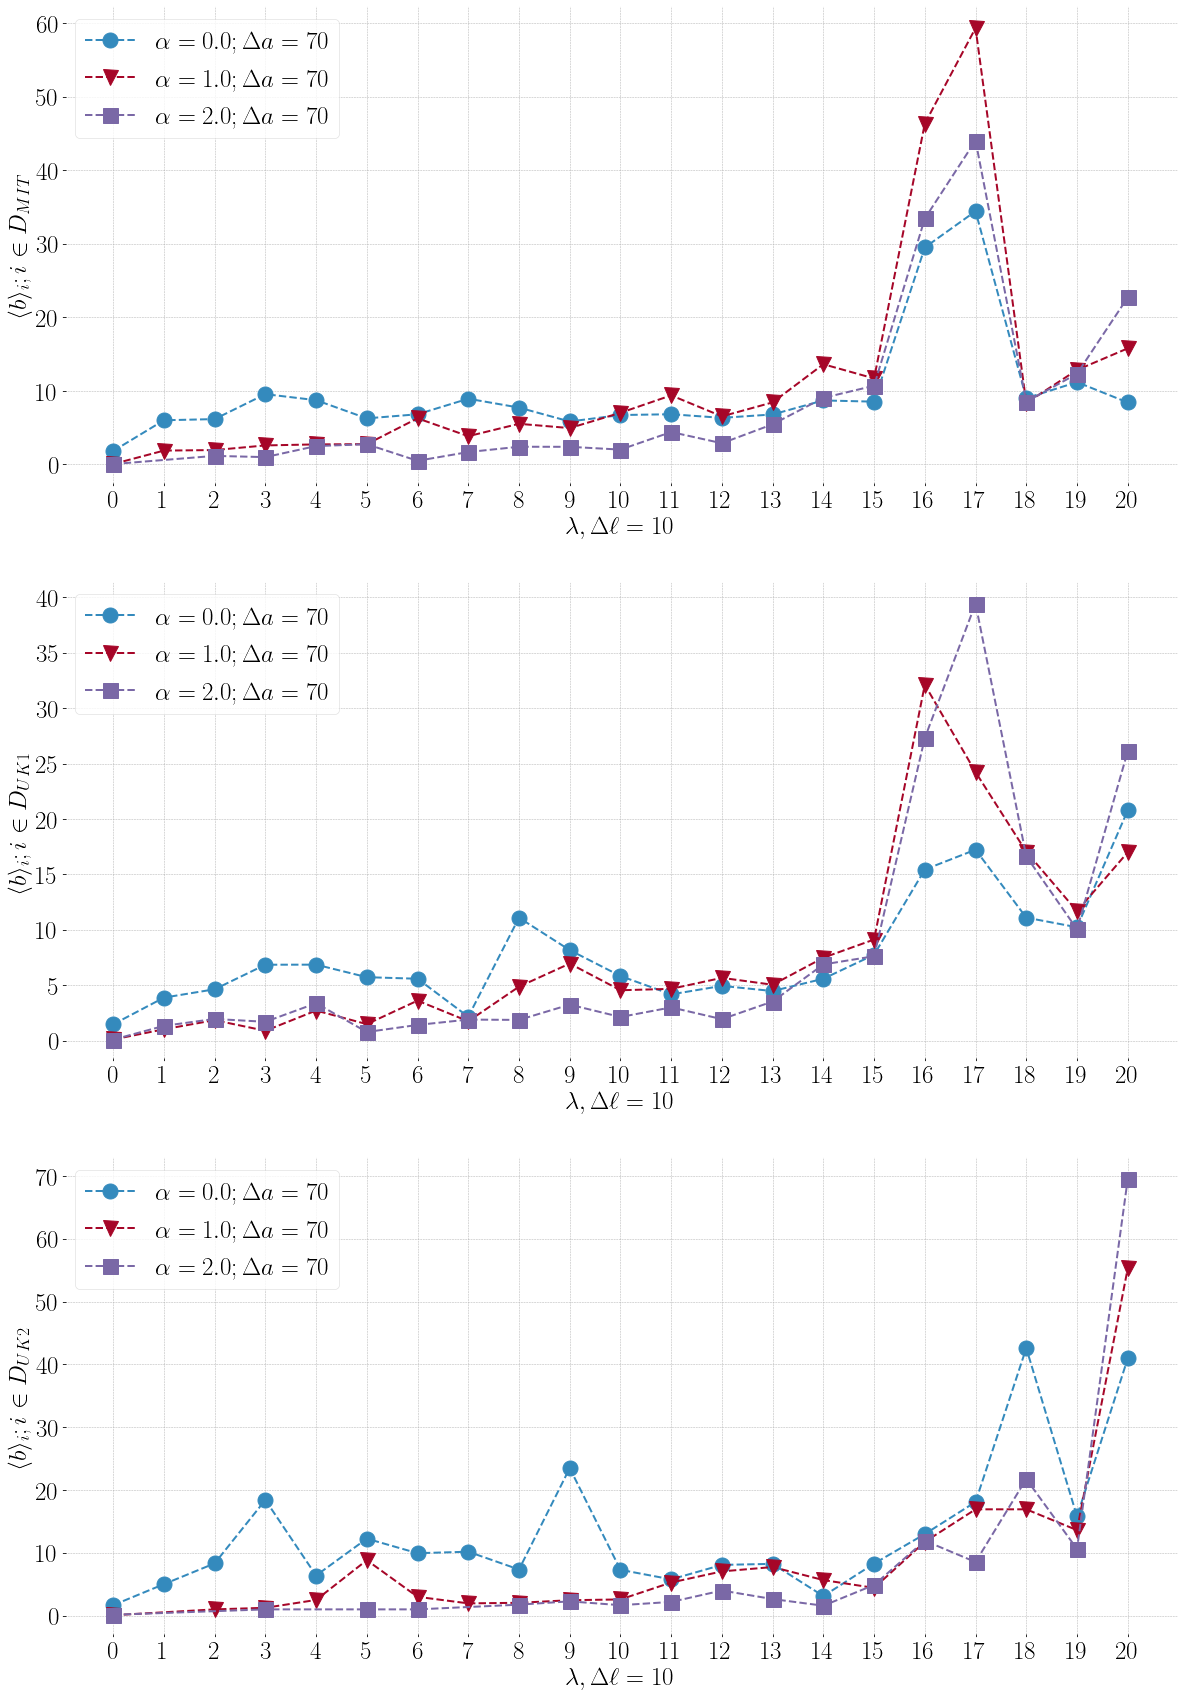

In [22]:
plt.figure(figsize=(20, 30))
p = 1
for c in bplot.keys():
    plt.subplot(3, 1, p)
    plt.xlabel(r"$\lambda, \Delta \ell = 10$")
    plt.ylabel(fr"$\langle b \rangle_i; i \in {['D_{MIT}', 'D_{UK1}', 'D_{UK2}'][p - 1]}$")
    plt.xticks(range(21))
    m = 0
    for alpha in bplot[c].keys():
        plt.plot(bplot[c][alpha].index, bplot[c][alpha]['lambda'], marker=markers[m], markersize=15, linestyle="--", label=fr'$\alpha = {alpha}; \Delta a = 70$')
        m += 1
    p += 1
    plt.legend()

## $\langle b \rangle$ as a function of $\alpha$

In [23]:
dff2 = {}
for c in calls.keys():
    %time dff2[c] = pc.get_f(calls[c], 'all', 10, 70)

/home/vsvh/docs/GMU/research/comm_patterns_git/phonecalls.py:204: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.sort_values(by='time', inplace=True)
/home/vsvh/docs/GMU/research/comm_patterns_git/phonecalls.py:209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['alpha'] = df3['aclock'] // bina


CPU times: user 9.08 s, sys: 17.1 ms, total: 9.1 s
Wall time: 9.1 s
CPU times: user 3.57 s, sys: 3.39 ms, total: 3.57 s
Wall time: 3.57 s
CPU times: user 2.38 s, sys: 3.47 ms, total: 2.38 s
Wall time: 2.38 s


In [24]:
bplot2 = {}
for c in dff2.keys():
    %time b = pc.get_b(dff2[c], 'alpha')
    %time bplot2[c] = pc.plot_g(b, 'alpha')

CPU times: user 2.92 s, sys: 19.9 ms, total: 2.94 s
Wall time: 2.94 s
CPU times: user 66.4 ms, sys: 0 ns, total: 66.4 ms
Wall time: 65.7 ms
CPU times: user 1.13 s, sys: 6.78 ms, total: 1.14 s
Wall time: 1.13 s
CPU times: user 37.5 ms, sys: 0 ns, total: 37.5 ms
Wall time: 37.3 ms
CPU times: user 710 ms, sys: 3.3 ms, total: 714 ms
Wall time: 713 ms
CPU times: user 32.3 ms, sys: 82 µs, total: 32.4 ms
Wall time: 31.7 ms


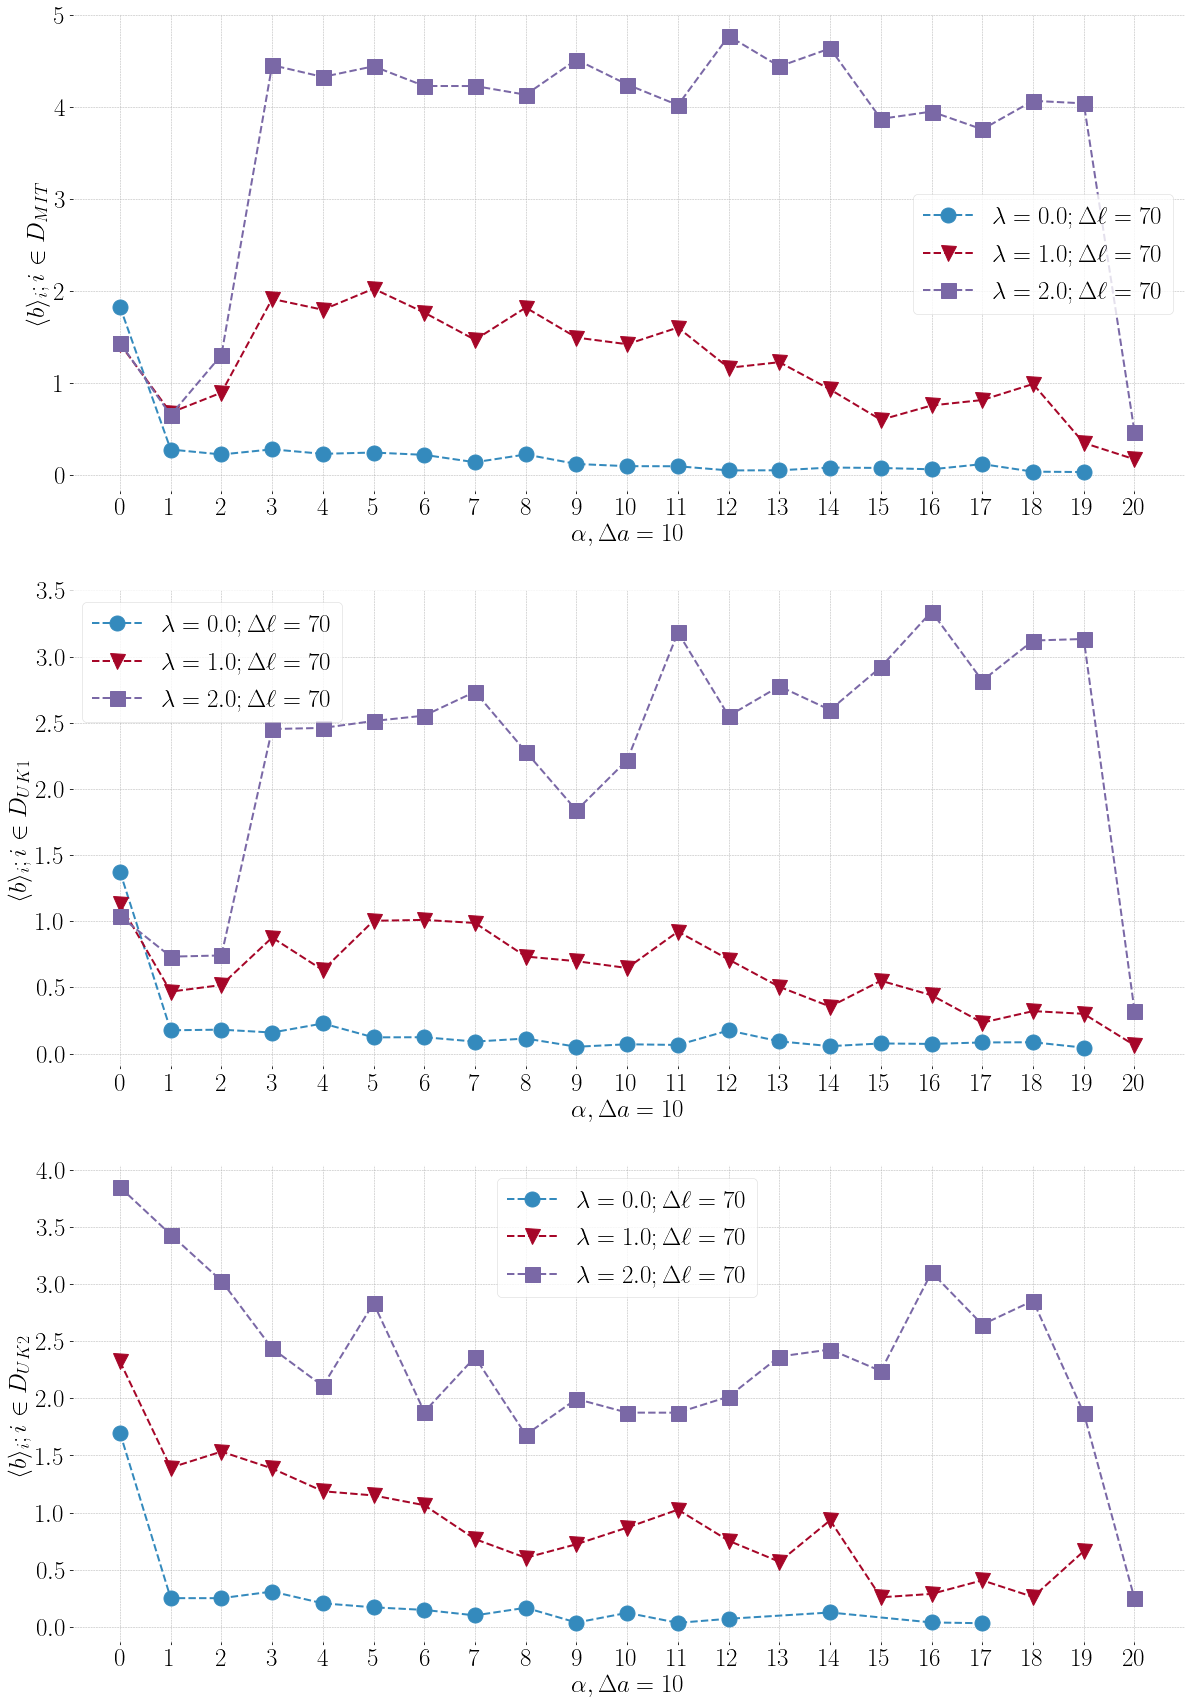

In [25]:
plt.figure(figsize=(20, 30))
p = 1
for c in bplot2.keys():
    plt.subplot(3, 1, p)
    plt.xlabel(r"$\alpha, \Delta a = 10$")
    plt.ylabel(fr"$\langle b \rangle_i; i \in {['D_{MIT}', 'D_{UK1}', 'D_{UK2}'][p - 1]}$")
    plt.xticks(range(21))
    m = 0
    for lamb in bplot2[c].keys():
        plt.plot(bplot2[c][lamb].index, bplot2[c][lamb]['alpha'], marker=markers[m], markersize=15, linestyle="--", label=fr'$\lambda = {lamb}; \Delta \ell = 70$')
        m += 1
    p += 1
    plt.legend()

# Lifetime separated by activity

In [26]:
fdist = {}
perc = {}
for c in dff.keys():
    allf = []
    for ego in dff[c].keys():
        for alter in dff[c][ego].keys():
            df = dff[c][ego][alter].loc[dff[c][ego][alter]['alpha'] == 1]
            for i in df['f']:
                allf.append(i)
    perc[c] = [np.percentile(allf, q) for q in (33, 66, 100)]
    fdist[c] = pc.f_histell(dff[c], 1, perc[c])

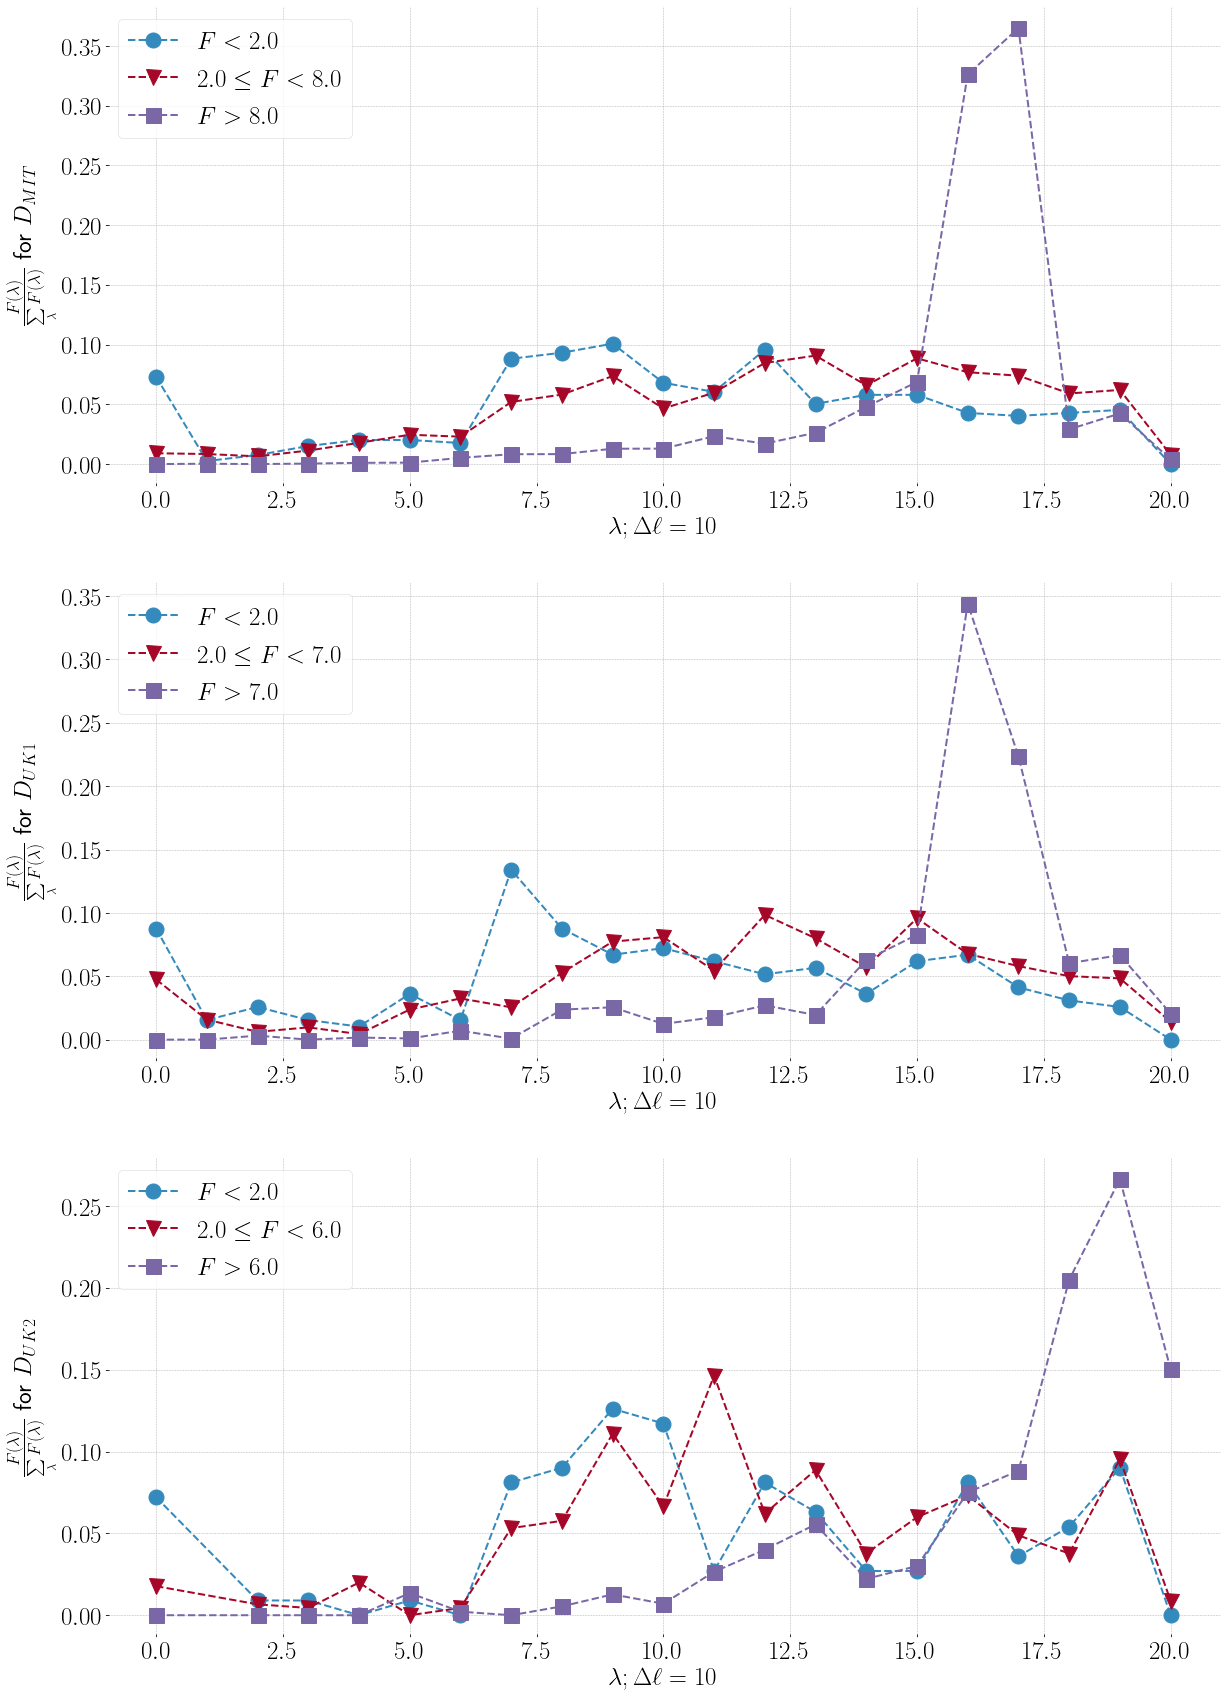

In [27]:
plt.figure(figsize=(20, 30))
p = 1
for c in fdist.keys():
    plt.subplot(3, 1, p)
    legends = [fr"$F < {perc[c][0]}$", fr"${perc[c][0]} \leq F < {perc[c][1]}$", fr"$F > {perc[c][1]}$", r"All $F$"]
    plt.xlabel(r"$\lambda; \Delta \ell = 10$")
    plt.ylabel(r"$\frac{F(\lambda)}{\sum\limits_{\lambda} F(\lambda)}$ " + fr" for ${['D_{MIT}', 'D_{UK1}', 'D_{UK2}'][p - 1]}$")
    for i in range(3):
        plt.plot(fdist[c][i].index, fdist[c][i][0] / sum(fdist[c][i][0]), marker=markers[i], linestyle="--", markersize=15, label=legends[i])
    plt.legend()
    p+=1

# $\phi$ as bins of activity

In [64]:
phi3 = {}
for c in dff.keys():
    phi3[c] = pc.f_histell(dff[c], 1, [], binned=True, deltaF=3)

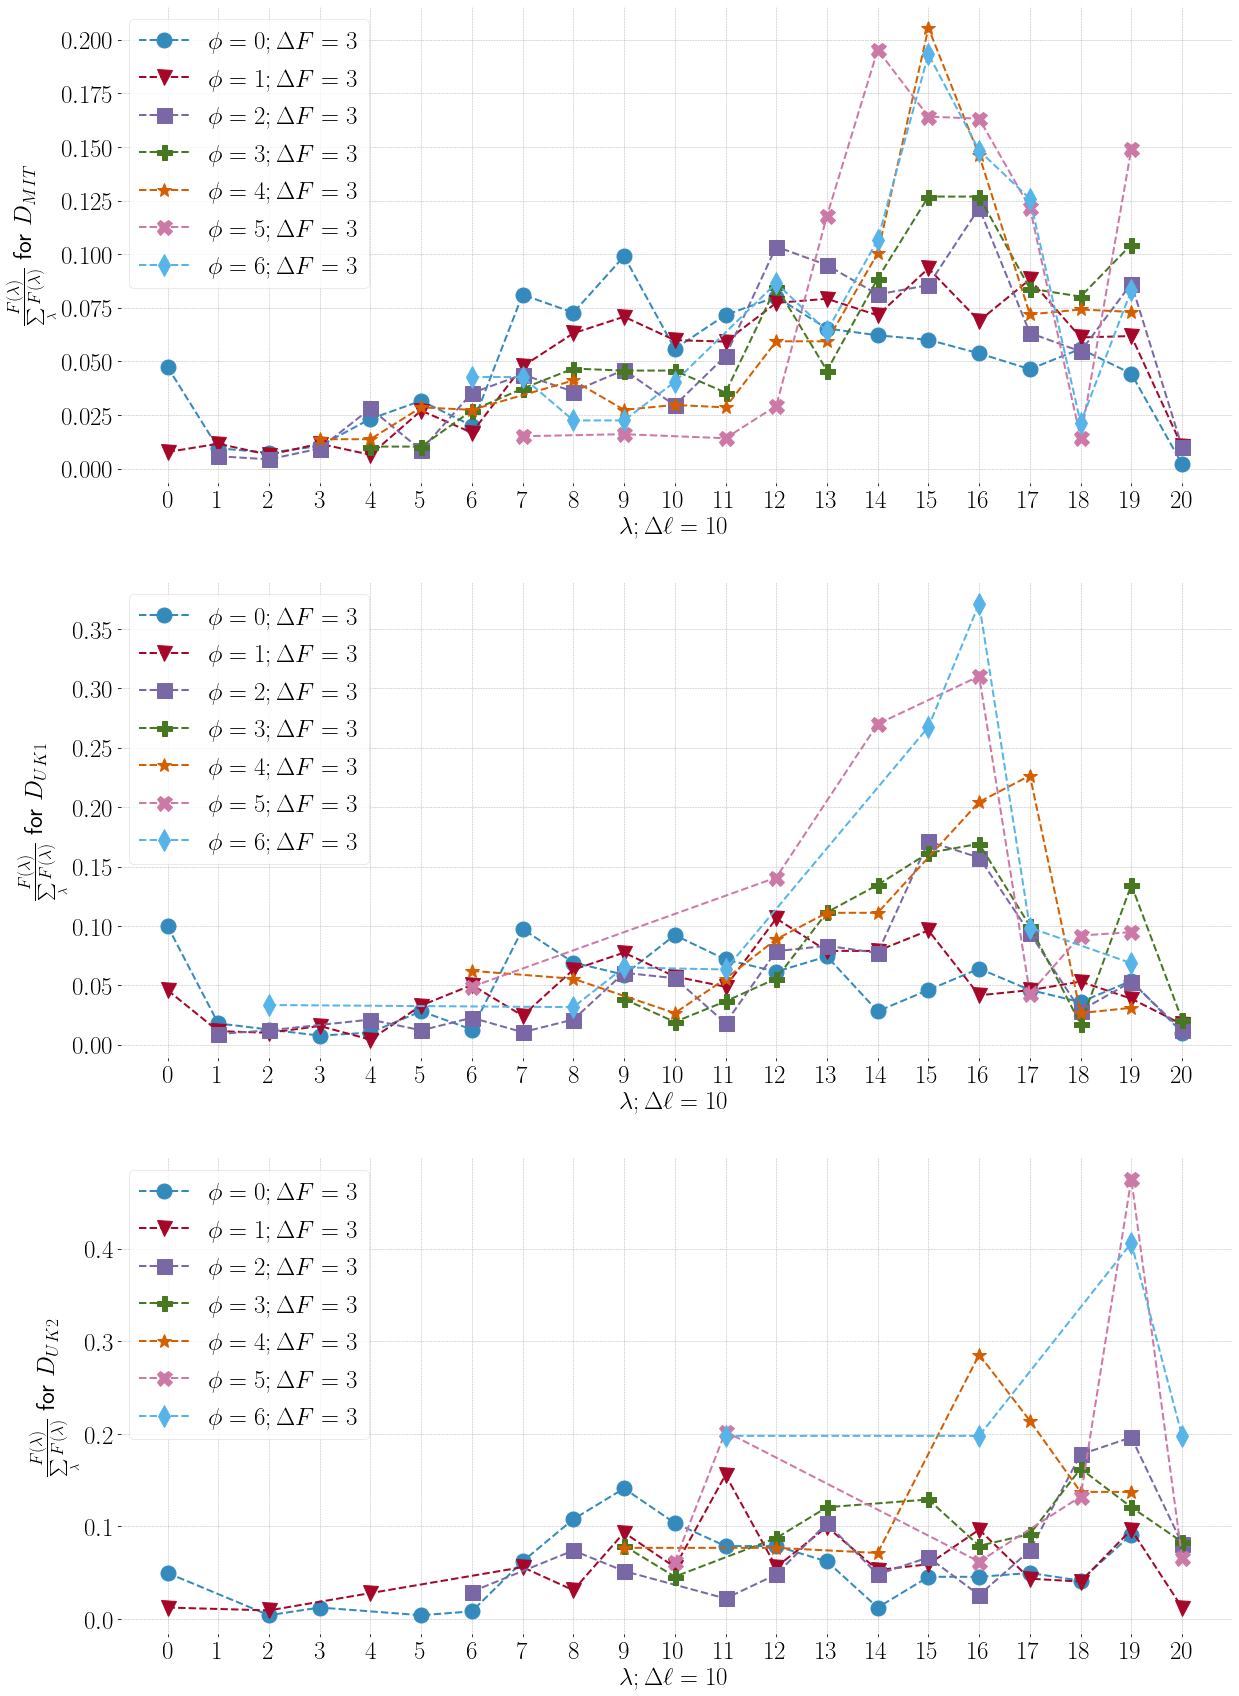

In [65]:
plt.figure(figsize=(20, 30))
p = 1
for c in phi3.keys():
    plt.subplot(3, 1, p)
    legends = [fr"$F < {perc[c][0]}$", fr"${perc[c][0]} \leq F < {perc[c][1]}$", fr"$F > {perc[c][1]}$", r"All $F$"]
    plt.xlabel(r"$\lambda; \Delta \ell = 10$")
    plt.ylabel(r"$\frac{F(\lambda)}{\sum\limits_{\lambda} F(\lambda)}$ " + fr" for ${['D_{MIT}', 'D_{UK1}', 'D_{UK2}'][p - 1]}$")
    plt.xticks(range(21))
    phis = sorted(phi3[c].keys())[:7]
    #phis += sorted(phi4[c].keys())[-20:-17]
    #print(sorted(phi4[c].keys()))
    m = 0
    for phi in phis:
        plt.plot(phi3[c][phi].index, phi3[c][phi][0] / sum(phi3[c][phi][0]), marker=markers[m], markersize=15, linestyle="--", label=fr"$\phi = {phi}; \Delta F = 3$")
        m += 1
    plt.legend()
    p += 1

# Probability of alter reaching $\lambda_c$

In [80]:
phi3 = {}
for c in dff.keys():
    phi3[c] = pc.f_histell(dff[c], 1, [], binned=True, deltaF=3)

result = {}
for c in phi3.keys():
    result[c] = {}
    for lambc in [15, 16, 17, 18]:
        result[c][lambc] = {}
        for phi in phi3[c].keys():
            df = phi3[c][phi]
            df['p'] = df[0] / sum(df[0])
            df2 = df.loc[df.index >= lambc]
            if len(df2) > 0:
                result[c][lambc][phi] = sum(df2['p'])
        result[c][lambc] = pd.DataFrame.from_dict(result[c][lambc], orient='index')
        result[c][lambc].sort_index(inplace=True)

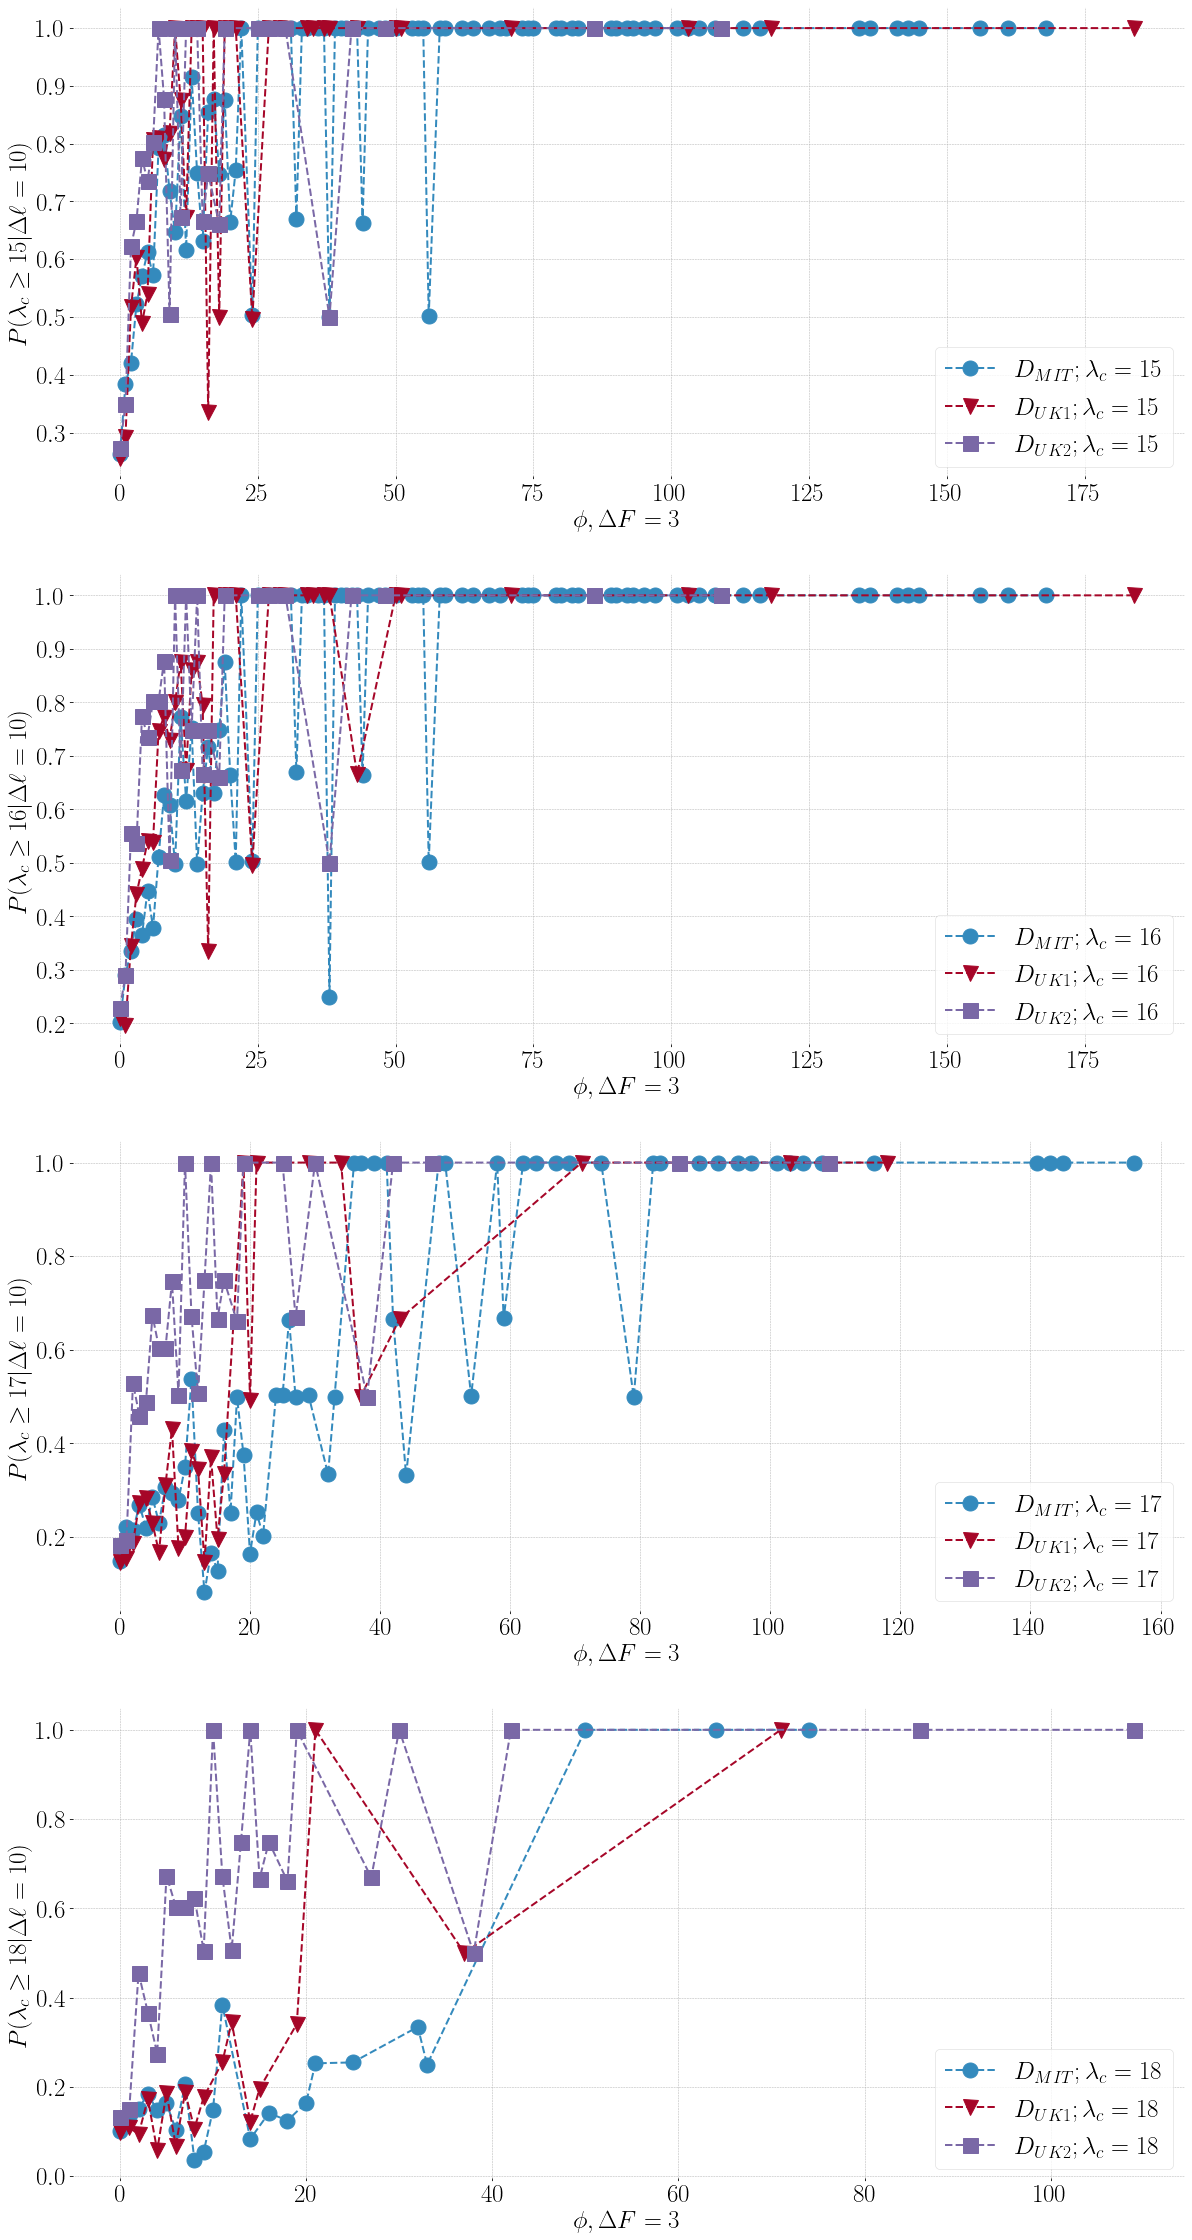

In [88]:
plt.figure(figsize=(20, 40))
p = 1
for lambc in [15, 16, 17, 18]:
    plt.subplot(4, 1, p)
    plt.xlabel(r"$\phi, \Delta F = 3$")
    plt.ylabel(fr"$P(\lambda_c \geq {lambc} | \Delta \ell = 10)$")
    m = 0
    for c in result.keys():
        plt.plot(result[c][lambc].index, result[c][lambc][0], marker=markers[m], markersize=15, linestyle="--", label=fr"${['D_{MIT}', 'D_{UK1}', 'D_{UK2}'][m]}; \lambda_c = {lambc}$")
        m += 1
    plt.legend()
    p += 1

In [85]:
result['mit'][15]

,0
0,0.262381
1,0.383773
2,0.421280
3,0.522388
4,0.570776
...,...
143,1.000000
145,1.000000
156,1.000000
161,1.000000
